In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv('noisy_sample_dataset.csv')

### Handling Missing Values

In [ ]:
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0) # Assuming that this is their first order
df['aisle_category'] = df['aisle_category'].fillna(df['aisle_category'].mode()[0]) # imputing with most frequent aisle category
df['department'] = df['department'].fillna(df['department'].mode()[0]) # imputing with most frequent department category

In [ ]:
# export the cleaned data
df.to_csv('data.csv', index=False)

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81086 entries, 0 to 81085
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                81086 non-null  int64  
 1   product_id              81086 non-null  int64  
 2   add_to_cart_order       81086 non-null  int64  
 3   reordered               81086 non-null  int64  
 4   user_id                 81086 non-null  int64  
 5   eval_set                81086 non-null  object 
 6   order_number            81086 non-null  int64  
 7   order_dow               81086 non-null  int64  
 8   order_hour_of_day       81086 non-null  object 
 9   days_since_prior_order  81086 non-null  float64
 10  product_name            81086 non-null  object 
 11  aisle_id                81086 non-null  int64  
 12  department_id           81086 non-null  int64  
 13  aisle                   81086 non-null  object 
 14  aisle_category          81086 non-null

### PRE-PROCESSING

In [ ]:
# copy the data
df_copy = df.copy()

In [ ]:
df_copy.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
aisle_category            0
department                0
dtype: int64

In [ ]:
df_copy.nunique()

order_id                  27066
product_id                14611
add_to_cart_order            71
reordered                     2
user_id                   54630
eval_set                      1
order_number                 99
order_dow                     7
order_hour_of_day            57
days_since_prior_order       61
product_name              14611
aisle_id                    134
department_id                21
aisle                       134
aisle_category                7
department                   22
dtype: int64

In [ ]:
df_copy = df_copy.drop(columns=['eval_set','department_id','user_id','product_id'])

In [ ]:
df_copy['order_hour_of_day'] = pd.to_numeric(df_copy['order_hour_of_day'], errors='coerce')

In [ ]:
numerical_values = df_copy.select_dtypes(include=['int64','float64'])
numerical_values

,order_id,add_to_cart_order,reordered,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id
0,133873,3,1,18,6,18.0,16.0,61
1,133874,2,0,3,0,11.0,3.0,88
2,133875,13,1,18,0,13.0,7.0,78
3,133875,2,0,6,0,13.0,6.0,16
4,133875,4,0,9,5,14.0,3.0,108
...,...,...,...,...,...,...,...,...
81081,160937,7,1,11,3,0.0,14.0,24
81082,160937,6,1,2,1,13.0,7.0,123
81083,160937,3,1,4,5,19.0,11.0,116
81084,160937,17,0,21,2,10.0,1.0,4


In [ ]:
categorical_values = df_copy.select_dtypes(include=['object'])
categorical_values

,product_name,aisle,aisle_category,department
0,Almond Cake,cookies cakes,Packaged Foods,snacks
1,Natural Honey Peanut Butter,spreads,Other,pantry
2,Whole Grain Sesame Rye Crisp Bread,crackers,Packaged Foods,snacks
3,Organic Cilantro,fresh herbs,Fresh Foods,produce
4,Part Skim Ricotta Cheese,other creams cheeses,Unknown,dairy eggs
...,...,...,...,...
81081,Organic Strawberries,fresh fruits,Fresh Foods,produce
81082,Stringless Sugar Snap Peas,packaged vegetables fruits,Packaged Foods,produce
81083,Berry Medley,frozen produce,Frozen & Refrigerated Items,frozen
81084,Yakisoba Chicken Flavor Noodles,instant foods,Packaged Foods,dry goods pasta


In [ ]:
from sklearn.preprocessing import LabelEncoder
# label encoding aisle_category and department
le = LabelEncoder()
categorical_values['aisle_category'] = le.fit_transform(categorical_values['aisle_category'])
categorical_values['department'] = le.fit_transform(categorical_values['department'])

In [ ]:
aisle_enc = pd.get_dummies(categorical_values['aisle'], prefix='aisle', drop_first=True)

In [ ]:
# product_name has too many values , so frequency encoding suits best
categorical_values['product_name_freq_enc'] = categorical_values['product_name'].map(categorical_values['product_name'].value_counts())

# we are dropping the original product_name
categorical_values = categorical_values.drop(columns=['product_name'])

In [ ]:
# droping the aisle as we have aisle_enc
categorical_values = categorical_values.drop(columns=['aisle'])

# here we are concatenating all the encoded columns
categorical_values_enc = pd.concat([categorical_values, aisle_enc], axis=1)
categorical_values_enc

,aisle_category,department,product_name_freq_enc,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,5,21,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,4,17,2,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,5,21,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,20,196,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,6,8,15,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81081,1,20,701,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81082,5,20,15,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81083,2,11,35,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
81084,5,10,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# convertign the df into sparseformat
categorical_values_enc_sparsed = categorical_values_enc.astype(pd.SparseDtype("int", fill_value=0))

# checking teh results
categorical_values_enc_sparsed.head()


,aisle_category,department,product_name_freq_enc,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,...,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt
0,5,21,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,17,2,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,5,21,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,20,196,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,8,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# aliginign the index
categorical_values_enc_sparsed.reset_index(drop=True, inplace=True)
numerical_values.reset_index(drop=True, inplace=True)

In [ ]:
# numerical and catergorical values concatinantion
cat_num_merged = pd.concat([categorical_values_enc_sparsed, numerical_values], axis=1)

### VISUALIZATIONS

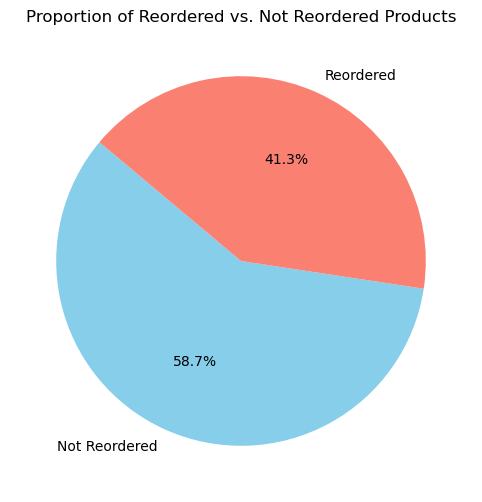

In [ ]:
# Calculate proportions
reordered_counts = df['reordered'].value_counts()
reordered_labels = ['Not Reordered', 'Reordered']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(
    reordered_counts,
    labels=reordered_labels,
    autopct='%1.1f%%',  # Show percentages
    startangle=140,  # Rotate for better view
    colors=['skyblue', 'salmon']  # Distinct colors
)
plt.title('Proportion of Reordered vs. Not Reordered Products')
plt.show()

The  not reorder percentage is greater than the reordered, it means that the majority of products are purchased only once, maybe because are less essential for the customers

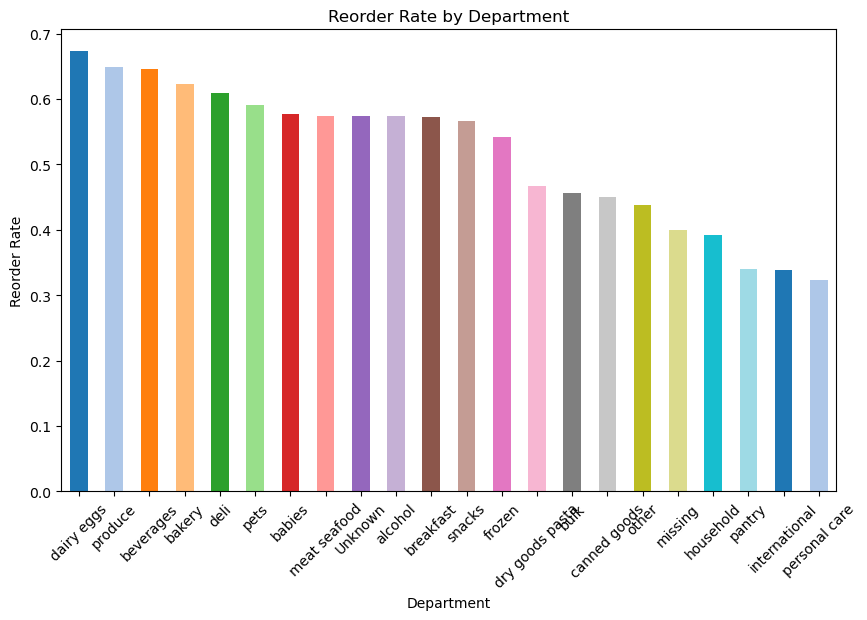

In [ ]:
# Aggregate reorder rates by department with observed=True
dept_reorder = (
    df.groupby('department', observed=True)['reordered']
    .mean()
    .sort_values(ascending=False)
)

# Plot
plt.figure(figsize=(10, 6))
dept_reorder.plot(kind='bar', color=plt.cm.tab20.colors)
plt.title('Reorder Rate by Department')
plt.xlabel('Department')
plt.ylabel('Reorder Rate')
plt.xticks(rotation=45)
plt.show()

We can see that "Dairy & Eggs" are a basic prod in the households and have the highest reorder rate

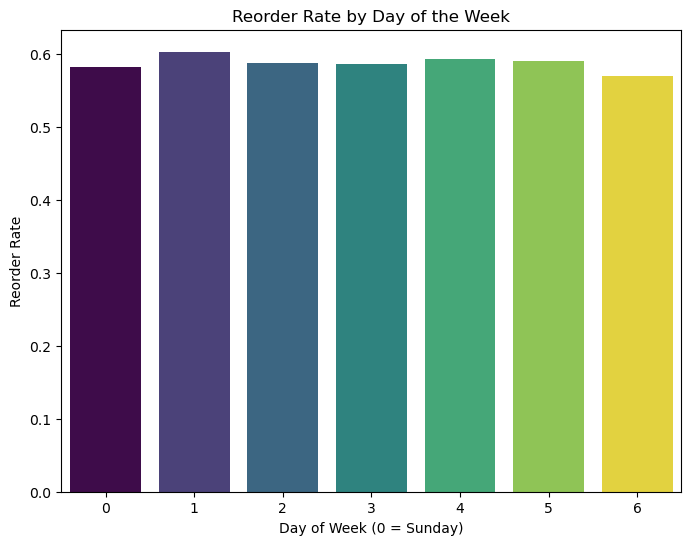

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x='order_dow',
    y='reordered',
    data=df,
    errorbar=None,
    hue='order_dow',
    palette='viridis',
    dodge=False
)

plt.title('Reorder Rate by Day of the Week')
plt.xlabel('Day of Week (0 = Sunday)')
plt.ylabel('Reorder Rate')


plt.legend([], [], frameon=False)

plt.show()

The day 1 is the one with the highest reorder rate, so is more likely the customers reorder product on Monday, maybe that means the customer trend to restocking groceries after the weekend, preparing for the week ahead. Marketing emails will be very effective on Sunday night, helping the sells the next day.

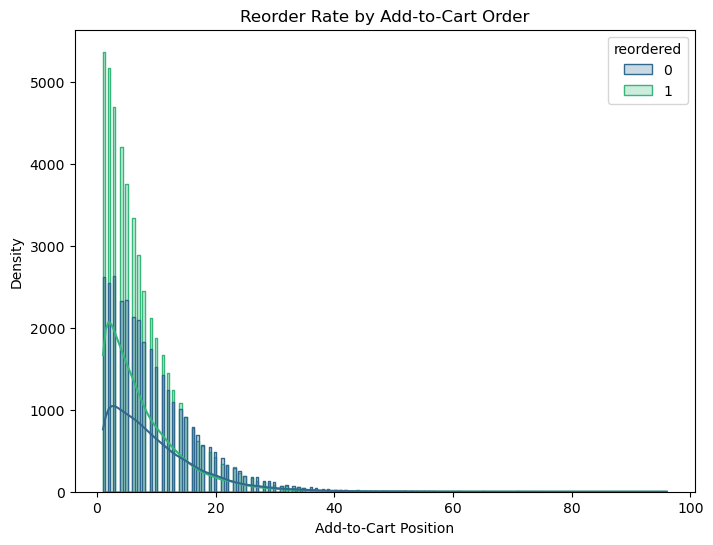

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='add_to_cart_order', hue='reordered', kde=True, element="step", palette='viridis')
plt.title('Reorder Rate by Add-to-Cart Order')
plt.xlabel('Add-to-Cart Position')
plt.ylabel('Density')
plt.show()

This plot shows that reorder a product is more likely on the first products added to the cart, that means the customers prioritize more regular purchased items because are part of their routines

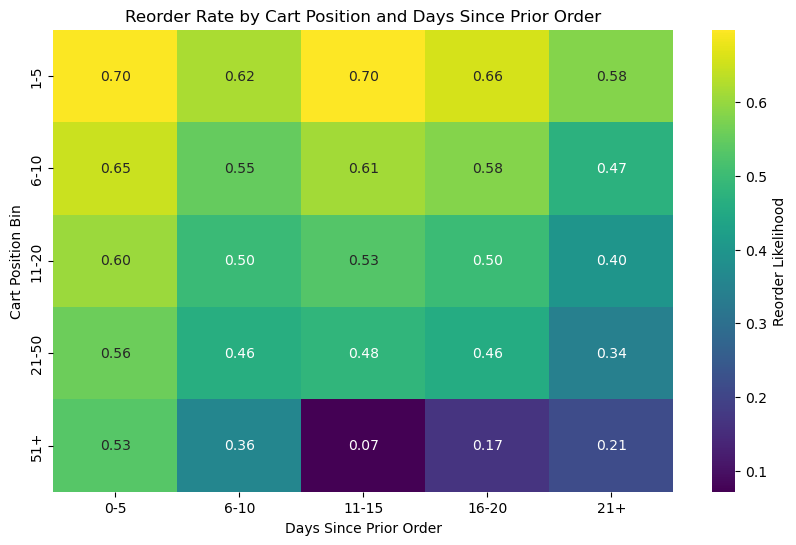

In [ ]:
# Bin `add_to_cart_order` and `days_since_prior_order`
df['cart_bin'] = pd.cut(df['add_to_cart_order'], bins=[0, 5, 10, 20, 50, 100], labels=['1-5', '6-10', '11-20', '21-50', '51+'])
df['days_bin'] = pd.cut(df['days_since_prior_order'], bins=[0, 5, 10, 15, 20, 30], labels=['0-5', '6-10', '11-15', '16-20', '21+'])

# Pivot table with observed=True to avoid FutureWarning
heatmap_data = df.pivot_table(index='cart_bin', columns='days_bin', values='reordered', aggfunc='mean', observed=True)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", cbar_kws={'label': 'Reorder Likelihood'})
plt.title('Reorder Rate by Cart Position and Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Cart Position Bin')
plt.show()

with this heatmap for bins of cart position and days since prior order we can analyze that the products added first to the cart are reorder more quickly, that identify a pattern or essential products that needs to be replaced frequently

### ASSOCIATION RULES

In [ ]:
# association rule mining
basket_data = df[['order_id', 'aisle_category']]

We try to analyze which aisle category are frequently purchased together in the cart transactions

In [ ]:
basket_data = basket_data.drop_duplicates()
basket_data = basket_data[basket_data['aisle_category'] != 'Unknown']


In [ ]:
# Create a pivot table
basket = basket_data.pivot_table(index='order_id', columns='aisle_category', aggfunc='size', fill_value=0)


In [ ]:
# Convert quantities to 1 and 0
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

/var/folders/8b/gvyhprgn3t764q19dkq1gt2c0000gp/T/ipykernel_95872/3603850989.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
from mlxtend.frequent_patterns import apriori

basket_bool = basket.astype(bool)

# Generate frequent itemsets
frequent_itemsets = apriori(basket_bool, min_support=0.005, use_colnames=True)



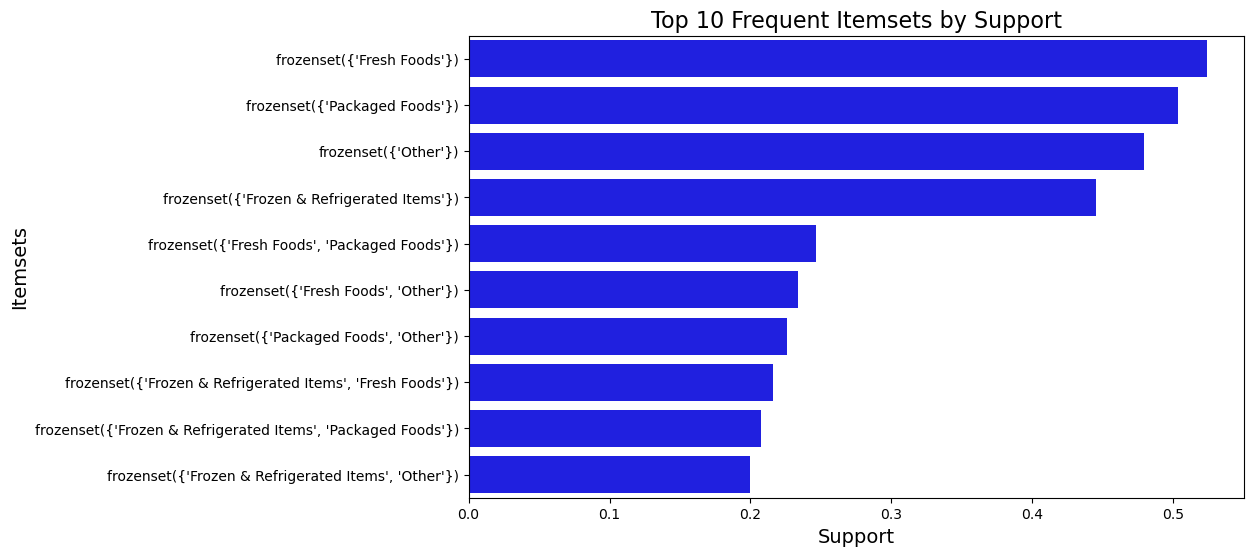

In [ ]:
top_frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemsets', data=top_frequent_itemsets, color='blue')
plt.title('Top 10 Frequent Itemsets by Support', fontsize=16)
plt.xlabel('Support', fontsize=14)
plt.ylabel('Itemsets', fontsize=14)
plt.show()


Generating frequent itemsets we analyze that Fresh Foods has the highest support, 51.86% of all transactions contain items from the "Fresh Foods" aisle category, this one is a highly purchased category ans is present in more than the half of all transactions

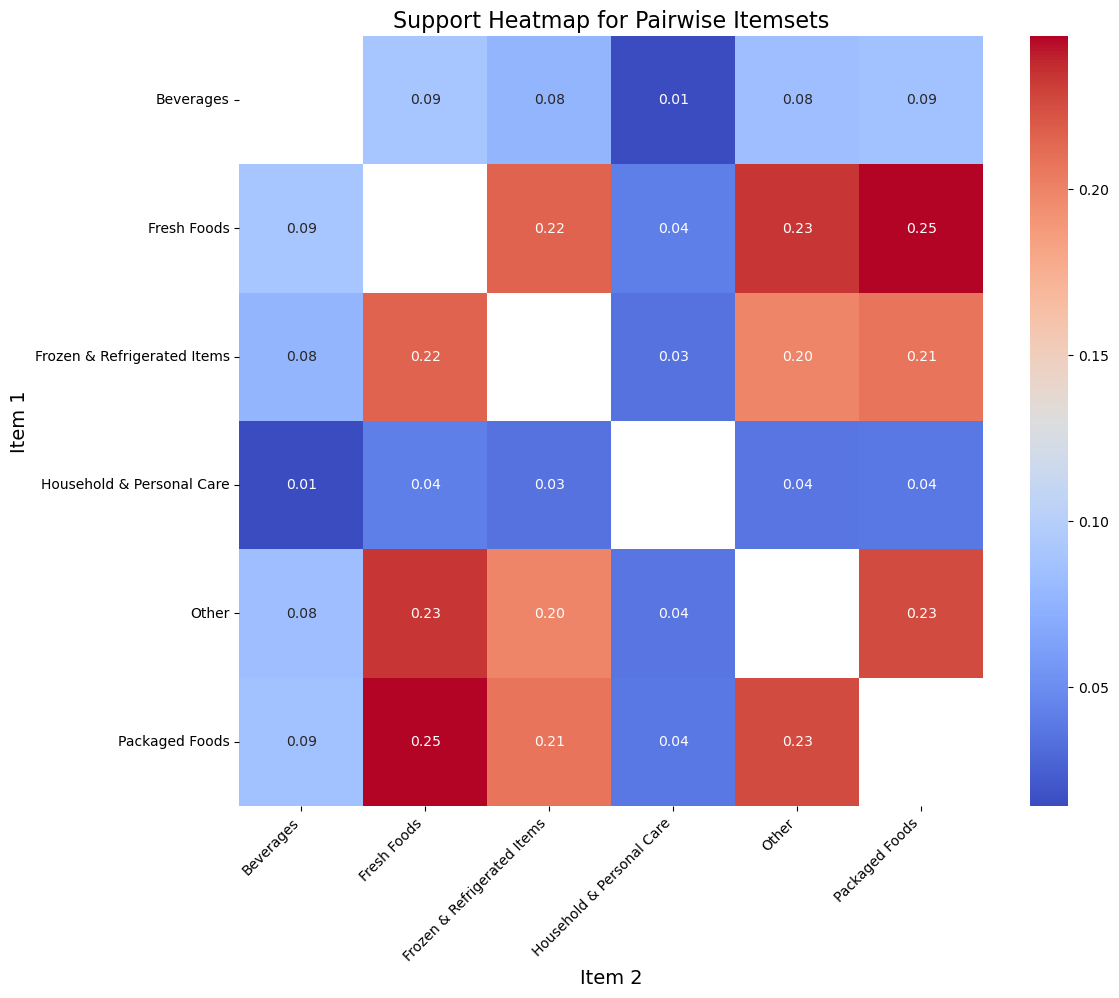

In [ ]:
# Extract multi-item itemsets for visualization
multi_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]

if not multi_itemsets.empty:
    # Create a pivot table for heatmap
    pairwise_itemsets = [
        (list(row['itemsets'])[0], list(row['itemsets'])[1], row['support'])
        for _, row in multi_itemsets.iterrows() if len(row['itemsets']) == 2
    ]

    if pairwise_itemsets:
        # Create the pivot table
        itemsets_pivot = pd.DataFrame(pairwise_itemsets, columns=['Item 1', 'Item 2', 'Support'])
        symmetric_pivot = itemsets_pivot.pivot(index='Item 1', columns='Item 2', values='Support')

        # Ensure symmetry
        symmetric_pivot = symmetric_pivot.combine_first(symmetric_pivot.T)

        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(symmetric_pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
        plt.title('Support Heatmap for Pairwise Itemsets', fontsize=16)
        plt.xlabel('Item 2', fontsize=14)
        plt.ylabel('Item 1', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()
    else:
        print("No pairwise itemsets found for visualization.")
else:
    print("No multi-item itemsets found for visualization.")




for the pairwise correlation plot of the itemsets we identify a strong relation between two categories packaged foods and fresh food,  indicate that the customers buy fresh food and complement the purchased with packaged snacks. Similar relation between fresh food and frozen & refrigerated.

In [ ]:
#export to csv
frequent_itemsets.to_csv('frequent_itemsets.csv', index=False)

In [ ]:
# count of unique order_id in the dataset
order_count = df['order_id'].nunique()
order_count

27066

In [ ]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.935, num_itemsets=27066)


(bread) -> (butter)

antecedent(trigger) -> consequent

Confidence: how often the item (Consequent) result from the antecedent


Lift: how likely the consequent occur when antecedent is present, lift > 1 positive association


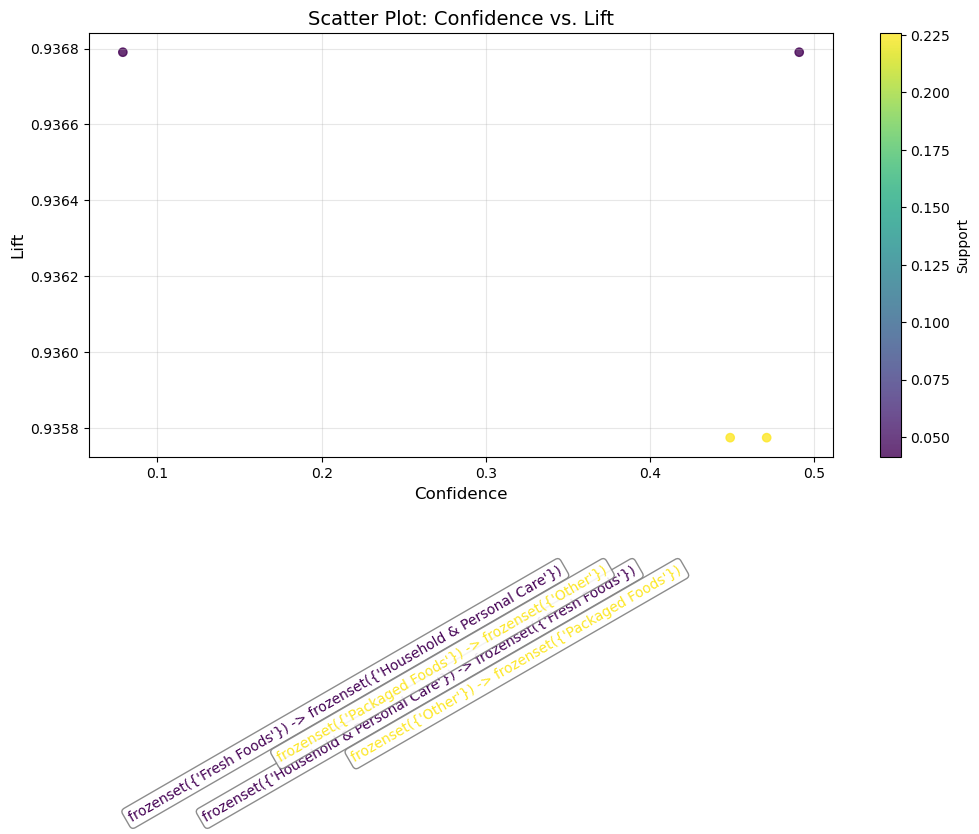

In [ ]:
# Scatter Plot: Confidence vs. Lift
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    rules['confidence'],
    rules['lift'],
    c=rules['support'],
    cmap='viridis',
    alpha=0.8
)
plt.colorbar(scatter, label='Support')
plt.title('Scatter Plot: Confidence vs. Lift', fontsize=14)
plt.xlabel('Confidence', fontsize=12)
plt.ylabel('Lift', fontsize=12)
plt.grid(alpha=0.3)

labels = [f"{rules['antecedents'][i]} -> {rules['consequents'][i]}" for i in range(len(rules))]
colors = scatter.to_rgba(rules['support'])

plt.subplots_adjust(bottom=0.35)
for i, label in enumerate(labels):
    plt.text(
        0.05 + i * 0.1,
        -0.25,
        label,
        color=colors[i],
        fontsize=10,
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.9),
        rotation=30,
        ha='left',
        va='top'
    )

plt.show()




base on the association rules, we can see that "fresh & food" (Antecedent)  and "household & personal care" (Consequent) has a high lift and confidence, so is very likely that when a customer buy "fresh & food" get a "household & personal care" product, so combine both kind of categories is good for a marketing campaign.

In [ ]:
# Export to csv
rules.to_csv('association_rules.csv', index=False)

# Deep Learning model

As deep learning models are widely recognized for their ability handle complex relationships and have both scalability and performance in large datasets, we will be using Neural Networks to predict if a product will be reordered or not based on features like the day of the week, hour, days since a user ordered it, among others.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data_mining/data.csv')
df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,aisle_category,department
0,133873,4191,3,1,139674,prior,18,6,18,16.0,Almond Cake,61,19,cookies cakes,Packaged Foods,snacks
1,133874,20382,2,0,9580,prior,3,0,11,3.0,Natural Honey Peanut Butter,88,13,spreads,Other,pantry
2,133875,18919,13,1,150073,prior,18,0,13,7.0,Whole Grain Sesame Rye Crisp Bread,78,19,crackers,Packaged Foods,snacks
3,133875,31717,2,0,199399,prior,6,0,13,6.0,Organic Cilantro,16,4,fresh herbs,Fresh Foods,produce
4,133875,38596,4,0,167885,prior,9,5,14,3.0,Part Skim Ricotta Cheese,108,16,other creams cheeses,Unknown,dairy eggs


In [ ]:
df.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81086 entries, 0 to 81085
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   order_id                81086 non-null  int64  
 1   product_id              81086 non-null  int64  
 2   add_to_cart_order       81086 non-null  int64  
 3   reordered               81086 non-null  int64  
 4   user_id                 81086 non-null  int64  
 5   eval_set                81086 non-null  object 
 6   order_number            81086 non-null  int64  
 7   order_dow               81086 non-null  int64  
 8   order_hour_of_day       81086 non-null  object 
 9   days_since_prior_order  81086 non-null  float64
 10  product_name            81086 non-null  object 
 11  aisle_id                81086 non-null  int64  
 12  department_id           81086 non-null  int64  
 13  aisle                   81086 non-null  object 
 14  aisle_category          81086 non-null

## Data Preparation for the Deep learning model


We can fill null values for the days since prior order column, as this are missing values due to not having a previous order or, in other words, being the first order. Because of this is correct to fill the null values with 0 as there are no days since prior order.

In [ ]:
df['days_since_prior_order'].fillna(0, inplace=True)
df.isnull().sum()

<ipython-input-162-ee72799d7008>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_prior_order'].fillna(0, inplace=True)


,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0


Convert to the appropiate numerical format

In [ ]:
df['order_hour_of_day'] = pd.to_numeric(df['order_hour_of_day'], errors='coerce')

Drop unnecesary columns for this deep learning model

In [ ]:
df.drop(columns=["product_name", "aisle", "department", "order_id", "order_number","aisle_id", "user_id", "eval_set", "department_id"], inplace=True)
df.columns

Index(['product_id', 'add_to_cart_order', 'reordered', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'aisle_category'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81086 entries, 0 to 81085
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              81086 non-null  int64  
 1   add_to_cart_order       81086 non-null  int64  
 2   reordered               81086 non-null  int64  
 3   order_dow               81086 non-null  int64  
 4   order_hour_of_day       80288 non-null  float64
 5   days_since_prior_order  81086 non-null  float64
 6   aisle_category          81086 non-null  object 
dtypes: float64(2), int64(4), object(1)
memory usage: 4.3+ MB


### Data Validation and Outliers handling

We should eliminate invalid values like hours of the day outside of the normal range (0-24)

<Axes: ylabel='order_hour_of_day'>

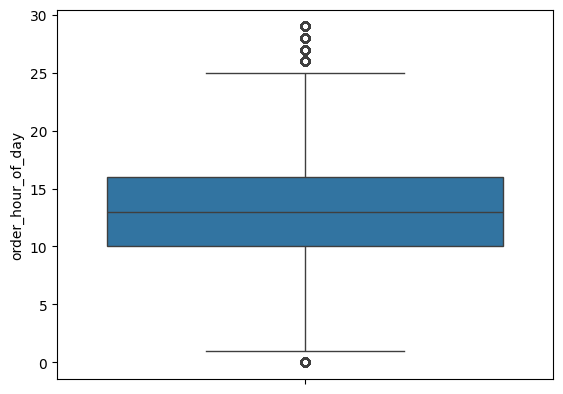

In [ ]:
import seaborn as sns
sns.boxplot(df['order_hour_of_day'])

In [ ]:
df['order_hour_of_day'].unique()

array([18., 11., 13., 14., 17., 15., 16., 23.,  0., 12., 10.,  8.,  9.,
       19., 20.,  6., 21.,  7., 22., nan, 25.,  3.,  5.,  1.,  2.,  4.,
       27., 29., 28., 26.])

In [ ]:
df['order_hour_of_day'] = df['order_hour_of_day'][df['order_hour_of_day'] <= 24]
df['order_hour_of_day'].unique()

array([18., 11., 13., 14., 17., 15., 16., 23.,  0., 12., 10.,  8.,  9.,
       19., 20.,  6., 21.,  7., 22., nan,  3.,  5.,  1.,  2.,  4.])

<Axes: ylabel='order_dow'>

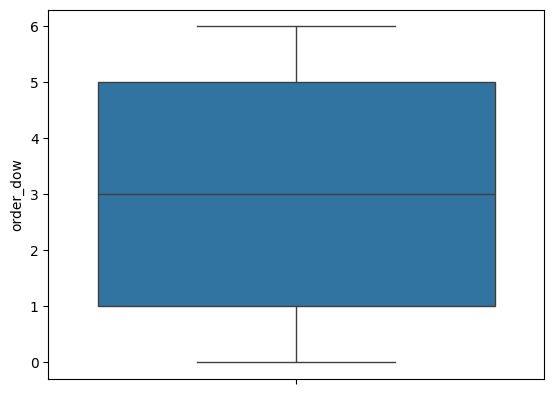

In [ ]:
sns.boxplot(df['order_dow'])

In [ ]:
df['order_dow'].unique()

array([6, 0, 5, 3, 2, 1, 4])

This column has significant outliers

<Axes: ylabel='days_since_prior_order'>

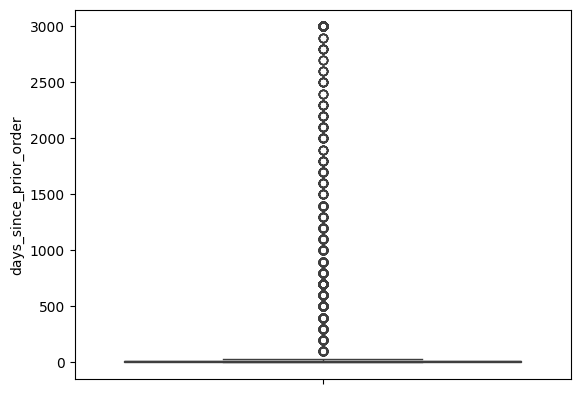

In [ ]:
sns.boxplot(df["days_since_prior_order"])

In [ ]:
df["days_since_prior_order"].describe()

,days_since_prior_order
count,81086.000000
mean,30.678231
std,186.714053
min,0.000000
25%,5.000000
50%,8.000000
75%,15.000000
max,3000.000000


In [ ]:
more_than_year =  df["days_since_prior_order"][df["days_since_prior_order"] > 30].count()
print("Outliers in Days since Prior order:", more_than_year)
print("Proportion of outliers:", round(more_than_year*100/df.shape[0], 2), "%")

Outliers in Days since Prior order: 1449
Proportion of outliers: 1.79 %


As the proportion of outliers is minimal, we can eliminate them:

<Axes: ylabel='days_since_prior_order'>

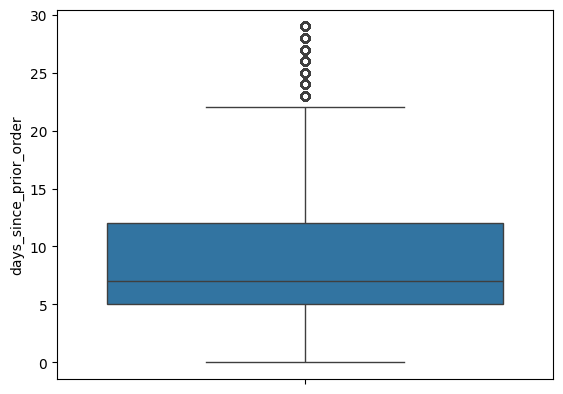

In [ ]:
df['days_since_prior_order'] =  df["days_since_prior_order"][df["days_since_prior_order"] < 30]
sns.boxplot(df['days_since_prior_order'])

### Handling missing values

In [ ]:
df.isnull().sum()

,0
product_id,0
add_to_cart_order,0
reordered,0
order_dow,0
order_hour_of_day,1571
days_since_prior_order,8906
aisle_category,0


For hours of the day we can add a cero for non previous order information

In [ ]:
# Fill missing values with 0
df['days_since_prior_order'].fillna(0, inplace=True)
df['days_since_prior_order'].isnull().sum()

<ipython-input-176-bb1a3616a798>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['days_since_prior_order'].fillna(0, inplace=True)


0

In [ ]:
# Fill missing values with mode
df['order_hour_of_day'].fillna(df['order_hour_of_day'].mode()[0], inplace=True)
df['order_hour_of_day'].isnull().sum()

<ipython-input-177-b477cfa9e96f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['order_hour_of_day'].fillna(df['order_hour_of_day'].mode()[0], inplace=True)


0

In [ ]:
df.isnull().sum()

,0
product_id,0
add_to_cart_order,0
reordered,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0
aisle_category,0


In [ ]:
df["aisle_category"].unique()

array(['Packaged Foods', 'Other', 'Fresh Foods', 'Unknown', 'Beverages',
       'Frozen & Refrigerated Items', 'Household & Personal Care'],
      dtype=object)

Apply one hot encoding to product to aisle_category that has 5 categories and make them 0 or 1

In [ ]:
# Perform one-hot encoding using pandas
one_hot = pd.get_dummies(df['aisle_category'], prefix='aisle_category', dtype=float)

# Concatenate the one-hot encoded columns to the original DataFrame
df = pd.concat([df, one_hot], axis=1)

# Show the updated DataFrame
df.head()

,product_id,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,aisle_category,aisle_category_Beverages,aisle_category_Fresh Foods,aisle_category_Frozen & Refrigerated Items,aisle_category_Household & Personal Care,aisle_category_Other,aisle_category_Packaged Foods,aisle_category_Unknown
0,4191,3,1,6,18.0,16.0,Packaged Foods,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20382,2,0,0,11.0,3.0,Other,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,18919,13,1,0,13.0,7.0,Packaged Foods,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,31717,2,0,0,13.0,6.0,Fresh Foods,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,38596,4,0,5,14.0,3.0,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Frequency encoding for product_id

In [ ]:
# frequency encoding for product_id
freq_encoding = df.groupby('product_id').size() / len(df)
df['product_id'] = df['product_id'].map(freq_encoding)
df.head()

,product_id,add_to_cart_order,reordered,order_dow,order_hour_of_day,days_since_prior_order,aisle_category,aisle_category_Beverages,aisle_category_Fresh Foods,aisle_category_Frozen & Refrigerated Items,aisle_category_Household & Personal Care,aisle_category_Other,aisle_category_Packaged Foods,aisle_category_Unknown
0,0.000012,3,1,6,18.0,16.0,Packaged Foods,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000025,2,0,0,11.0,3.0,Other,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000012,13,1,0,13.0,7.0,Packaged Foods,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.002417,2,0,0,13.0,6.0,Fresh Foods,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.000185,4,0,5,14.0,3.0,Unknown,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can also eliminate the unknown category values as they are not very representative

In [ ]:
(df['aisle_category_Unknown'] == 1).sum()

4002

In [ ]:
df.drop(columns=["aisle_category_Unknown", "aisle_category"], inplace=True)

In [ ]:
print(df.describe())

         product_id  add_to_cart_order     reordered     order_dow  \
count  81086.000000       81086.000000  81086.000000  81086.000000   
mean       0.001112           8.373196      0.587142      2.740054   
std        0.002408           7.180807      0.492351      2.087572   
min        0.000012           1.000000      0.000000      0.000000   
25%        0.000062           3.000000      0.000000      1.000000   
50%        0.000222           6.000000      1.000000      3.000000   
75%        0.000913          12.000000      1.000000      5.000000   
max        0.013960          96.000000      1.000000      6.000000   

       order_hour_of_day  days_since_prior_order  aisle_category_Beverages  \
count       81086.000000            81086.000000              81086.000000   
mean           13.349320                7.913388                  0.068002   
std             4.234366                6.458062                  0.251751   
min             0.000000                0.000000         

## Train-test split

In [ ]:
# Assuming `df` is your original DataFrame
X = df.drop('reordered', axis=1)  # Features (all columns except 'reordered')
y = df['reordered']  # Target variable

# Split the data (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of your data after splitting
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (64868, 11)
X_test shape: (16218, 11)


## Training

In [ ]:
# function to create the Keras model with hyperparameters
def create_model(optimizer='adam', dropout_rate=0.2, neurons=128):
    model = Sequential([
        Dense(neurons, input_dim=X_train.shape[1], activation='relu'),  # Input layer for your data
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters grid, using 'model__' prefix for model parameters
param_grid = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.2, 0.3],
    'model__neurons': [64, 128, 256],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the grid search to your data
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__neurons': 256, 'model__optimizer': 'adam'}
Best Score: 0.6311894079652863


In [ ]:
# Deep learning classification model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))  # Regularization to prevent overfitting
# Hidden layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# Hidden layer 2
model.add(Dense(32, activation='relu'))
# Output layer: For predicting binary values (0 or 1), use a sigmoid activation
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Step 6: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2028/2028 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5851 - loss: 0.6883 - val_accuracy: 0.5914 - val_loss: 0.6668
Epoch 2/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5943 - loss: 0.6688 - val_accuracy: 0.5915 - val_loss: 0.6667
Epoch 3/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5974 - loss: 0.6647 - val_accuracy: 0.6049 - val_loss: 0.6596
Epoch 4/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5965 - loss: 0.6633 - val_accuracy: 0.6026 - val_loss: 0.6601
Epoch 5/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6052 - loss: 0.6599 - val_accuracy: 0.6051 - val_loss: 0.6588
Epoch 6/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6062 - loss: 0.6581 - val_accuracy: 0.6046 - val_loss: 0.6573
Epoch 7/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6014 - loss: 0.6599 - val_accuracy: 0.6017 - val_loss: 0.6588
Epoch 8/50
2028/2028 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6096 - loss: 0.6567 - val_accurac

## Evaluation

Evaluating the results we can see that the model have opportunities to be improved, as both the train and test sets are having an accuracy bellow 70%

### Visualization of training and validation loss & accuracy

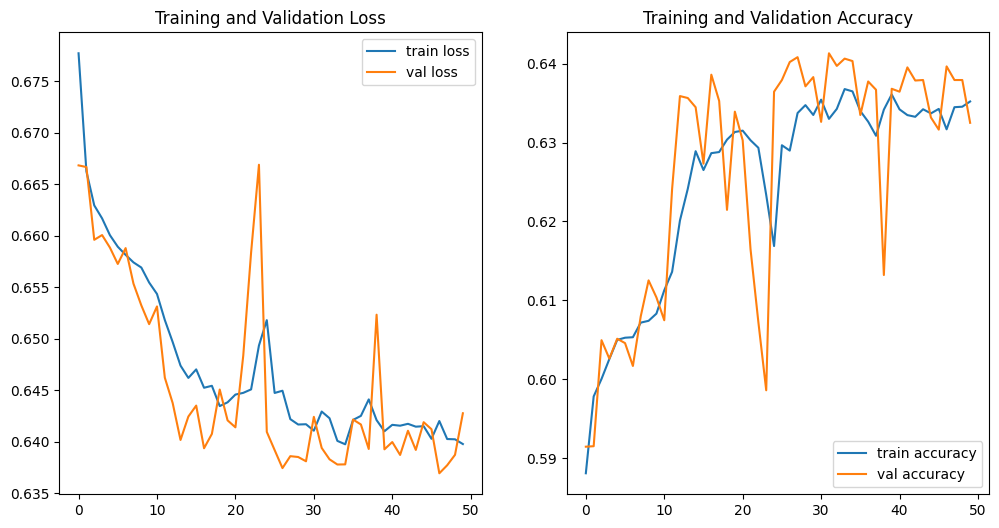

In [ ]:
# Plot training & validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
!pip install scikeras

In [ ]:
# Evaluate the model on the test set with the best parameters
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)

# Convert predictions to binary
y_pred_binary = (y_pred > 0.5).astype(int)

# Step 8: Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.36      0.45      6739
           1       0.65      0.84      0.73      9479

    accuracy                           0.64     16218
   macro avg       0.63      0.60      0.59     16218
weighted avg       0.63      0.64      0.61     16218



507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


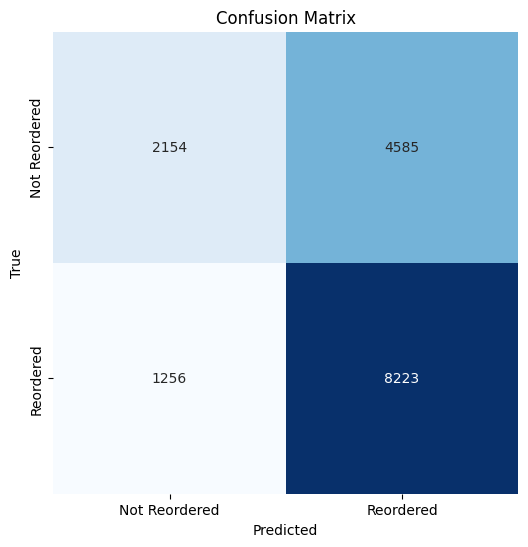

In [ ]:
# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary (0 or 1)

# Step 2: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Step 3: Plot the confusion matrix using Seaborn heatmap for better visualization
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Reordered', 'Reordered'],
            yticklabels=['Not Reordered', 'Reordered'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()